In [34]:
import os

isColab = False
isKaggle = False

# Directory di default
current_dir = os.getcwd()

try:
    if not isColab:
        raise ImportError("We are not in google colab")
    from google.colab import drive

    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/[2025-2026]\\ AN2DL/Challenge\\ 1/dataset"
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
    isColab = True

except ImportError:
    # Rilevamento ambiente Kaggle
    if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") or os.path.exists("/kaggle/working") or isKaggle:
        isKaggle = True
        kaggle_work_dir = "/kaggle/working/AN2DL-challenge-1"
        os.makedirs(kaggle_work_dir, exist_ok=True)
        current_dir = kaggle_work_dir
        print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    else:
        isColab = False
        isKaggle = False
        print("Esecuzione locale. Salto mount Google Drive.")
        local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1"
        current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
        print(f"Directory corrente impostata a: {current_dir}")

# Cambio directory se non Colab (su Colab è già fatto con %cd)
if not isColab:
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

Esecuzione locale. Salto mount Google Drive.
Directory corrente impostata a: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1


In [35]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch

torch.manual_seed(SEED)
# from torchsummary import summary

logs_dir = "tensorboard"
if isColab:
    !pkill -f tensorboard
else:
    # Arresta eventuali processi tensorboard in locale (Windows)
    import os

    if os.name == 'nt':
        try:
            import psutil

            for proc in psutil.process_iter(['name', 'cmdline']):
                name = (proc.info.get('name') or '').lower()
                cmd = ' '.join(proc.info.get('cmdline') or []).lower()
                if 'tensorboard' in name or 'tensorboard' in cmd:
                    try:
                        proc.kill()
                    except Exception:
                        pass
        except ImportError:
            import subprocess

            subprocess.run(['taskkill', '/F', '/IM', 'tensorboard.exe'],
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

%load_ext tensorboard
if isColab:
    !mkdir -p models
else:
    os.makedirs("../models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu130
Device: cuda


In [36]:
import os
import zipfile

# --- 1. Impostazioni ---
competition_name = 'an2dl2526c1'
dataset_path = 'dataset'
if isKaggle:
    dataset_path = '/kaggle/input/pirate-pain/dataset'
train_file = 'pirate_pain_train.csv'
test_file = 'pirate_pain_test.csv'
labels_file = 'pirate_pain_train_labels.csv'
sample_submission_file = 'sample_submission.csv'

# Controlla se il dataset è già stato scaricato ed estratto
if not isKaggle and not isColab and not os.path.exists(os.path.join(dataset_path, train_file)):
    # --- 2. Autenticazione e Download ---
    from kaggle.api.kaggle_api_extended import KaggleApi

    # Inizializza l'API di Kaggle
    # L'autenticazione avviene automaticamente se 'kaggle.json' è in C:\\Users\\Bert0ns\\.kaggle\\
    api = KaggleApi()
    api.authenticate()

    print(f"Download del dataset dalla competizione '{competition_name}'...")

    # Crea la directory di destinazione se non esiste
    os.makedirs(dataset_path, exist_ok=True)

    # Scarica i file della competizione nella cartella 'dataset'
    api.competition_download_files(competition_name, path=dataset_path)

    # Estrai i file dall'archivio zip
    zip_path = os.path.join(dataset_path, f'{competition_name}.zip')
    if os.path.exists(zip_path):
        print(f"Estrazione dei file da '{zip_path}'...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        # Rimuovi il file zip dopo l'estrazione
        os.remove(zip_path)
        print("Estrazione completata e file zip rimosso.")
    else:
        print("ATTENZIONE: File zip non trovato. Il download potrebbe non essere riuscito.")
else:
    print(f"Il dataset è già presente nella cartella {dataset_path}. Download saltato.")


Il dataset è già presente nella cartella dataset. Download saltato.


In [37]:
import pandas as pd

# Load the datasets
if not isColab:
    dataset_df = pd.read_csv(os.path.join(dataset_path, train_file))
    kaggle_test_df = pd.read_csv(os.path.join(dataset_path, test_file))
    labels_df = pd.read_csv(os.path.join(dataset_path, labels_file))
else:  # Per Simo che usa colab in modo strano
    dataset_df = pd.read_csv('pirate_pain_train.csv')
    kaggle_test_df = pd.read_csv('pirate_pain_test.csv')
    labels_df = pd.read_csv('pirate_pain_train_labels.csv')

In [38]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline

# 2. Identifica colonne
id_cols = ['sample_index', 'time']
cat_cols = ['n_legs', 'n_hands', 'n_eyes']
num_cols = [c for c in dataset_df.columns if c not in id_cols + cat_cols]

# 3. Preprocessore: one-hot per categoriche + standardizzazione numeriche
preprocessore = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ]
)

# 4. Modello di outlier detection (per riga)
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.01,  # percentuale attesa di outlier, da calibrare
    random_state=SEED
)

pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessore),
        ('model', iso_forest)
    ]
)

# 5. Adatta il modello e calcola score per ogni riga (step temporale)
X = dataset_df[id_cols + cat_cols + num_cols].copy()
pipeline.fit(X)

# decision_function: valori >0 normali, <0 outlier
dataset_df['outlier_score_step'] = pipeline.decision_function(X)
dataset_df['is_outlier_step'] = pipeline.predict(X)  # -1 = outlier, 1 = normale

# 6. Aggrega a livello di sequenza (sample_index)
agg_funcs = {
    'outlier_score_step': ['mean', 'min'],
    'is_outlier_step': lambda s: (s == -1).mean()  # % di step outlier
}
seq_outliers = (
    dataset_df.groupby('sample_index')
    .agg(agg_funcs)
)

seq_outliers.columns = [
    'score_mean',
    'score_min',
    'ratio_step_outlier'
]
seq_outliers = seq_outliers.reset_index()

# 7. Definisci outlier a livello di sample_index
# es.: sequenze con >20% di step outlier
soglia_ratio = 0.5
seq_outliers['is_outlier_seq'] = seq_outliers['ratio_step_outlier'] > soglia_ratio

# 8. Visualizza i sample_index più sospetti
sospetti = seq_outliers.sort_values('score_mean').head(20)
print(sospetti)

     sample_index  score_mean  score_min  ratio_step_outlier  is_outlier_seq
44             44   -0.066144  -0.142263             0.83750            True
338           338   -0.048791  -0.193617             0.88125            True
137           137   -0.014150  -0.095766             0.61250            True
496           496   -0.002305  -0.027732             0.51875            True
350           350    0.029217   0.007015             0.00000           False
252           252    0.029239  -0.117721             0.42500           False
416           416    0.032923  -0.060657             0.21875           False
8               8    0.042420  -0.079480             0.04375           False
216           216    0.050203   0.017390             0.00000           False
123           123    0.054216  -0.141224             0.25625           False
234           234    0.057414  -0.088697             0.21875           False
267           267    0.070846  -0.042733             0.03125           False

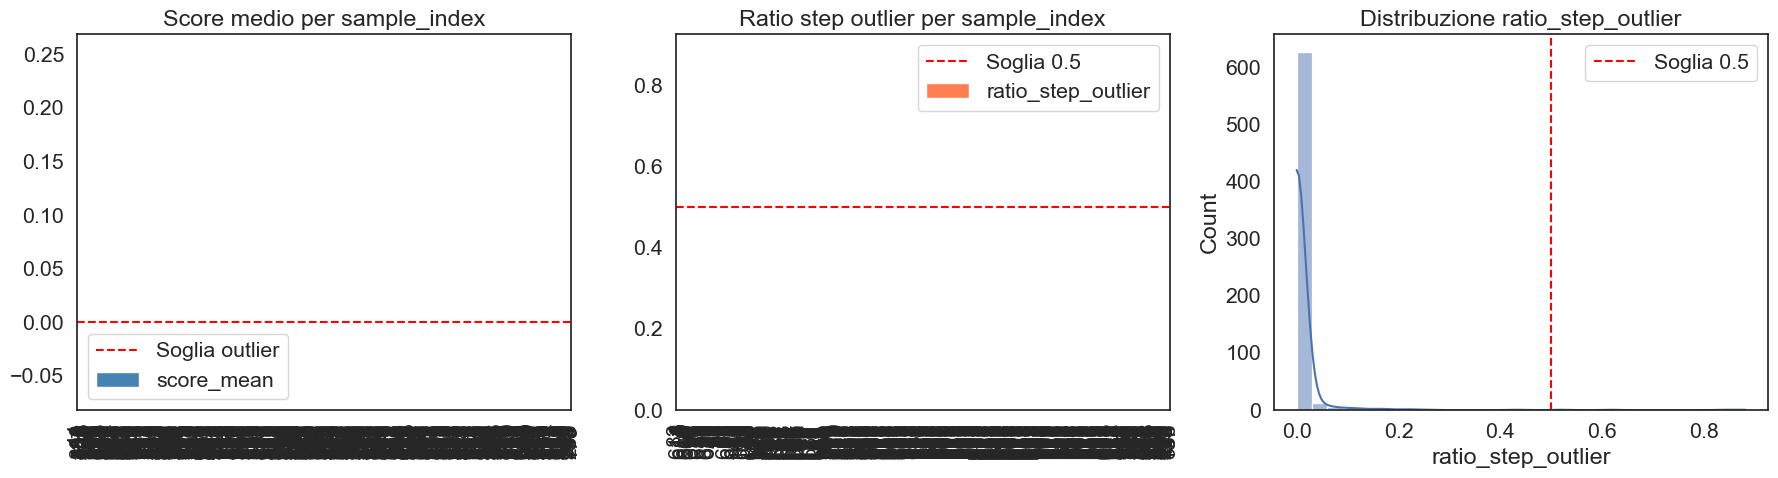

In [39]:
# 1. Distribuzione degli score per sequenza
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Score medio
seq_outliers.sort_values('score_mean')['score_mean'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Score medio per sample_index')
axes[0].axhline(0, color='red', linestyle='--', label='Soglia outlier')
axes[0].legend()

# Ratio step outlier
seq_outliers.sort_values('ratio_step_outlier')['ratio_step_outlier'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Ratio step outlier per sample_index')
axes[1].axhline(soglia_ratio, color='red', linestyle='--', label=f'Soglia {soglia_ratio}')
axes[1].legend()

# Distribuzione ratio
sns.histplot(seq_outliers['ratio_step_outlier'], bins=30, ax=axes[2], kde=True)
axes[2].axvline(soglia_ratio, color='red', linestyle='--', label=f'Soglia {soglia_ratio}')
axes[2].set_title('Distribuzione ratio_step_outlier')
axes[2].legend()

plt.tight_layout()
plt.show()

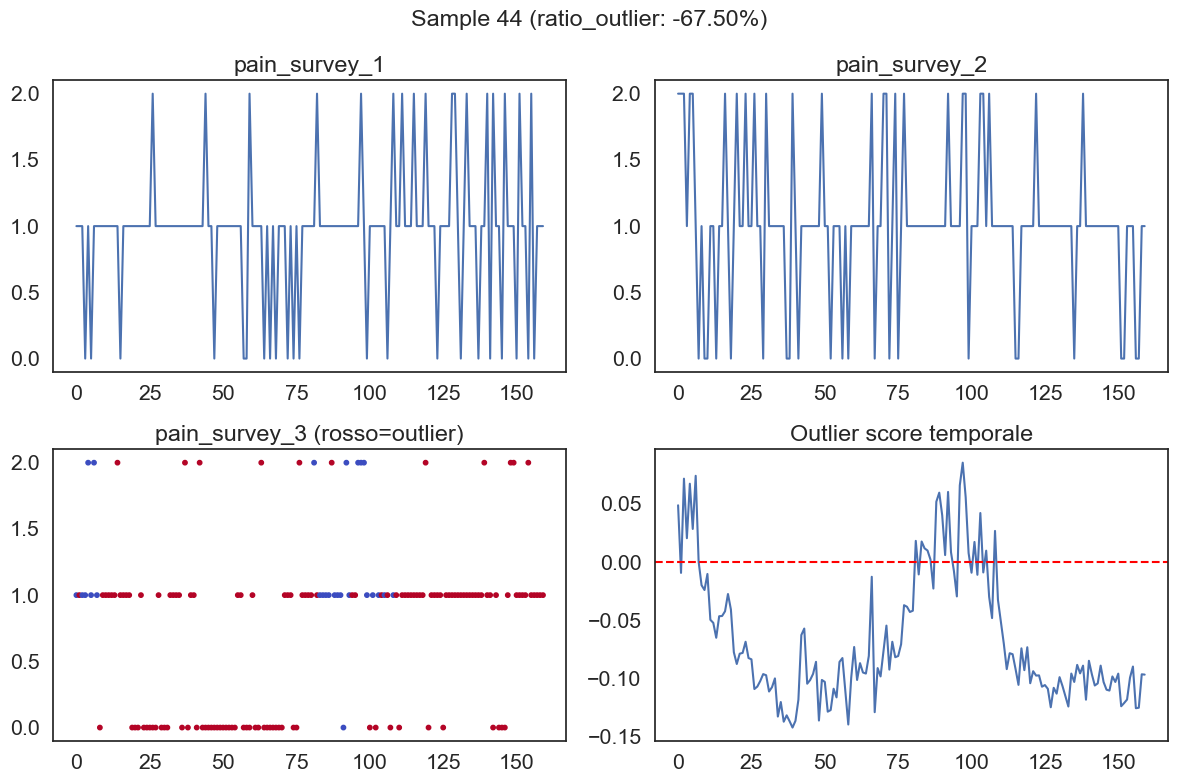

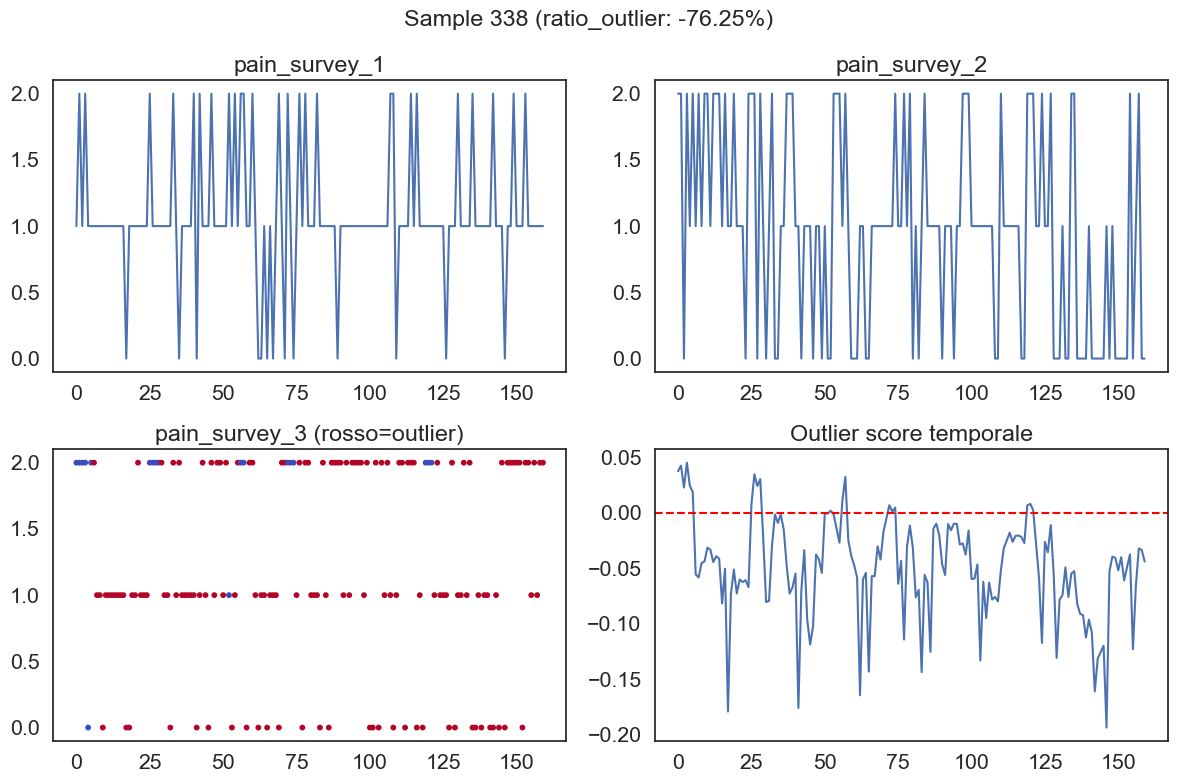

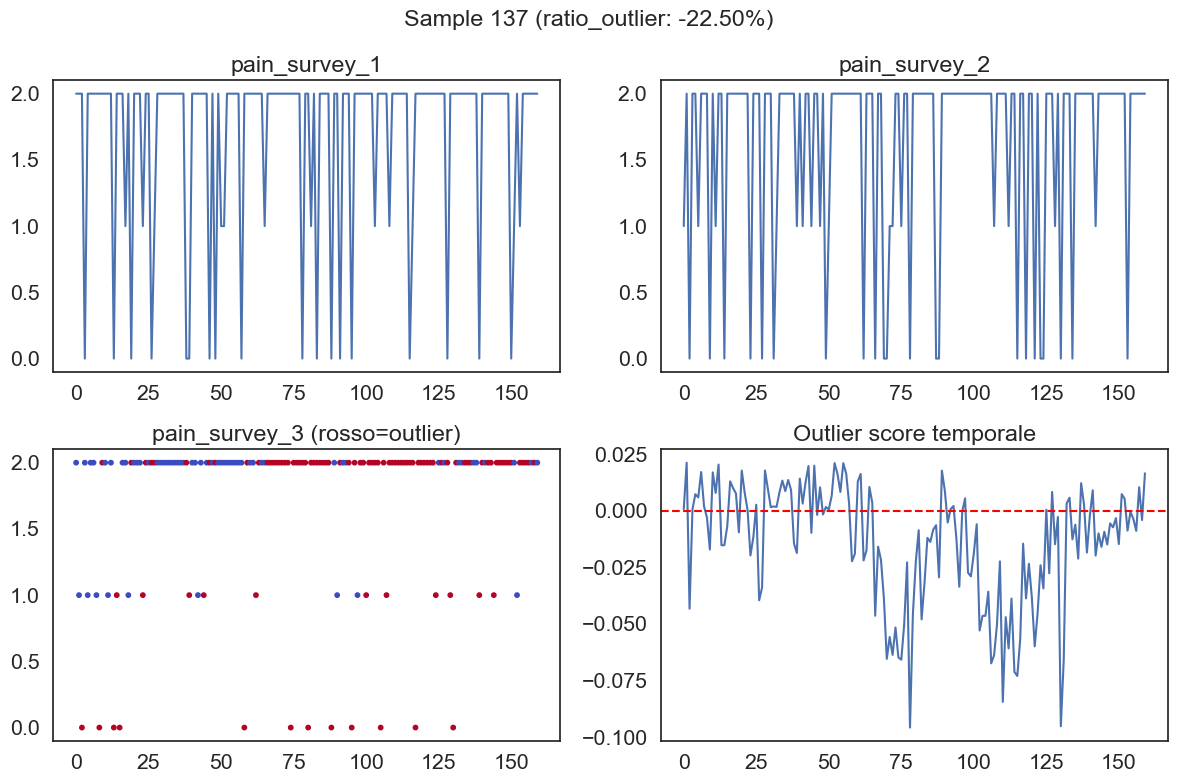

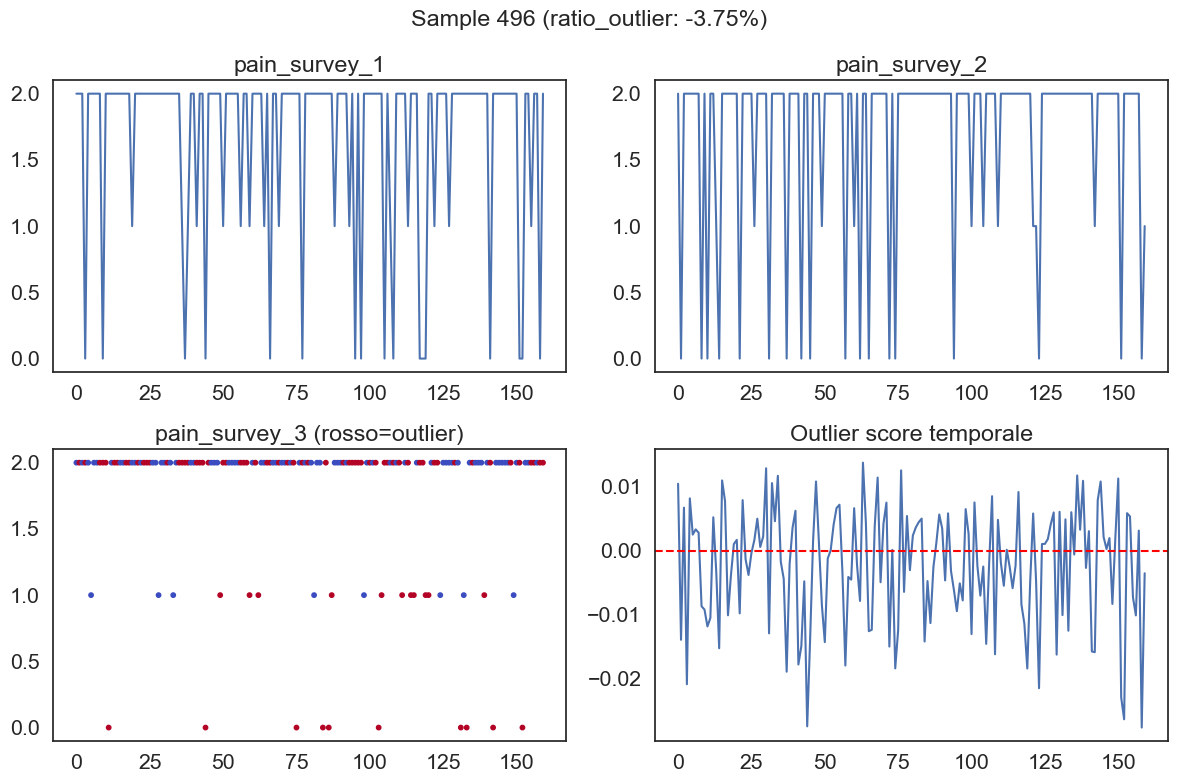

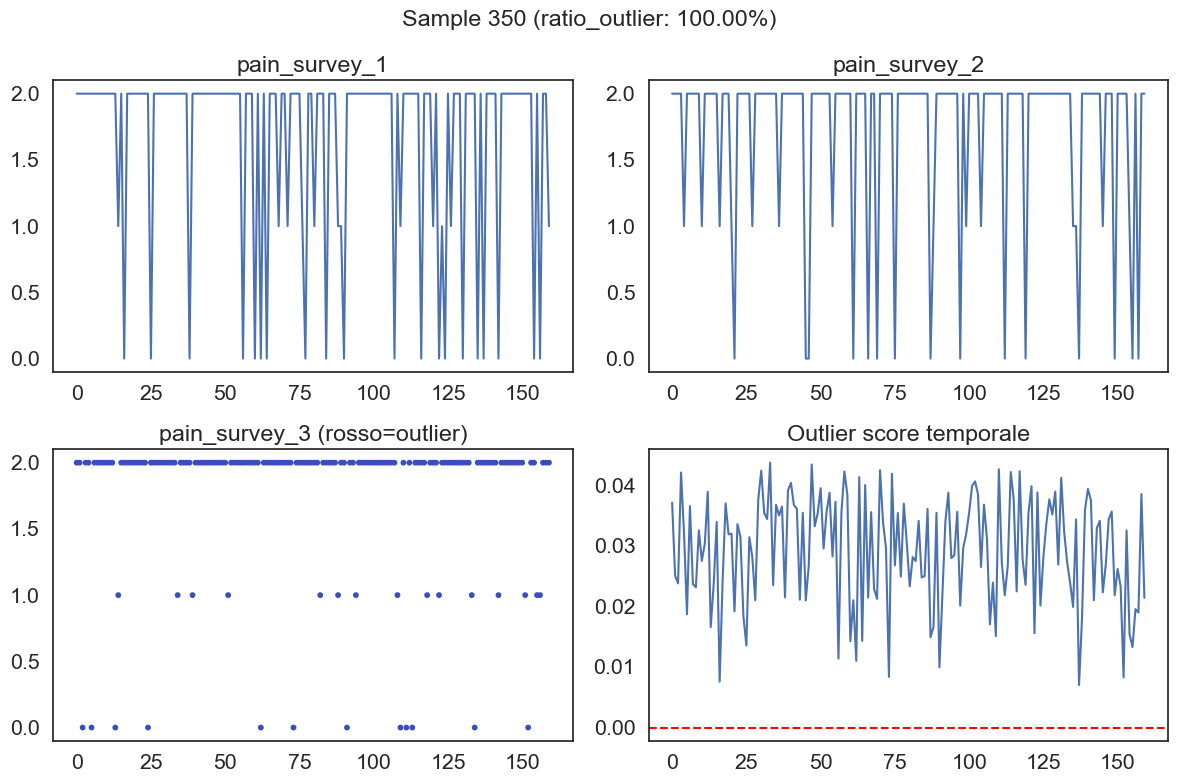

In [40]:
# Prendi i 5 sample_index con score medio più basso
worst_samples = seq_outliers.nsmallest(5, 'score_mean')['sample_index'].values

# Plotta alcune feature temporali
for sample_id in worst_samples:
    sample_data = dataset_df[dataset_df['sample_index'] == sample_id]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Sample {sample_id} (ratio_outlier: {sample_data["is_outlier_step"].mean():.2%})')

    # Plotta alcune feature numeriche
    axes[0, 0].plot(sample_data['time'], sample_data[num_cols[0]])
    axes[0, 0].set_title(num_cols[0])

    axes[0, 1].plot(sample_data['time'], sample_data[num_cols[1]])
    axes[0, 1].set_title(num_cols[1])

    # Colora gli outlier
    outlier_mask = sample_data['is_outlier_step'] == -1
    axes[1, 0].scatter(sample_data['time'], sample_data[num_cols[2]],
                       c=outlier_mask, cmap='coolwarm', s=10)
    axes[1, 0].set_title(f'{num_cols[2]} (rosso=outlier)')

    axes[1, 1].plot(sample_data['time'], sample_data['outlier_score_step'])
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Outlier score temporale')

    plt.tight_layout()
    plt.show()

In [41]:
# Filtra il dataset rimuovendo sequenze problematiche
clean_samples = seq_outliers[seq_outliers['is_outlier_seq'] == False]['sample_index'].values
df_clean = dataset_df[dataset_df['sample_index'].isin(clean_samples)]

print(f"Dataset originale: {len(dataset_df['sample_index'].unique())} sequenze")
print(f"Dataset pulito: {len(df_clean['sample_index'].unique())} sequenze")
print(f"Rimossi: {len(dataset_df['sample_index'].unique()) - len(df_clean['sample_index'].unique())} sequenze")

Dataset originale: 661 sequenze
Dataset pulito: 657 sequenze
Rimossi: 4 sequenze
